In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# 決定木

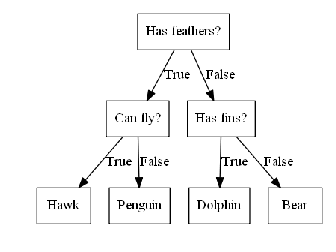

In [2]:
mglearn.plots.plot_animal_tree()

決定木を適用すると過剰適合することが多い<br>
過剰適合を抑制する方法は２つ<br>
構築過程で木の生成を早めに止める事前枝刈り<br>
構築後に情報の少ないノードを削除する事後枝刈り（ただの枝刈りともいう）<br>
scikit-learnでは事前枝刈りのみ実装されている

In [3]:
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,stratify=cancer.target,random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
print("訓練セット:{:.3f}".format(tree.score(X_train,y_train)))
print("検証セット:{:.3f}".format(tree.score(X_test,y_test)))

訓練セット:1.000
検証セット:0.937


枝刈りを行っていないため訓練セットへの精度は100%となっているが過剰適合している<br>
検証セットに対してもまだ上がる余地がありそう<br>
木が完全に訓練データに適合する前に、木が一定の深さになったらそこで止める<br>
max_depthパラメタで指定できる

In [4]:
tree = DecisionTreeClassifier(max_depth = 4,random_state=0)
tree.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(tree.score(X_train,y_train)))
print("検証セット:{:.3f}".format(tree.score(X_test,y_test)))

訓練セット:0.988
検証セット:0.951


# 決定木の解析

treeモジュールのexport_graphvizを使用すると木を可視化できる<br>
dotファイル形式（グラフを格納するテキストファイル）でファイルを書き出せる<br>

In [5]:
from sklearn.tree import export_graphviz
export_graphviz(tree,out_file="tree.dot",class_names = ["malignant","benign"],feature_names=cancer.feature_names,impurity=False,filled=True)

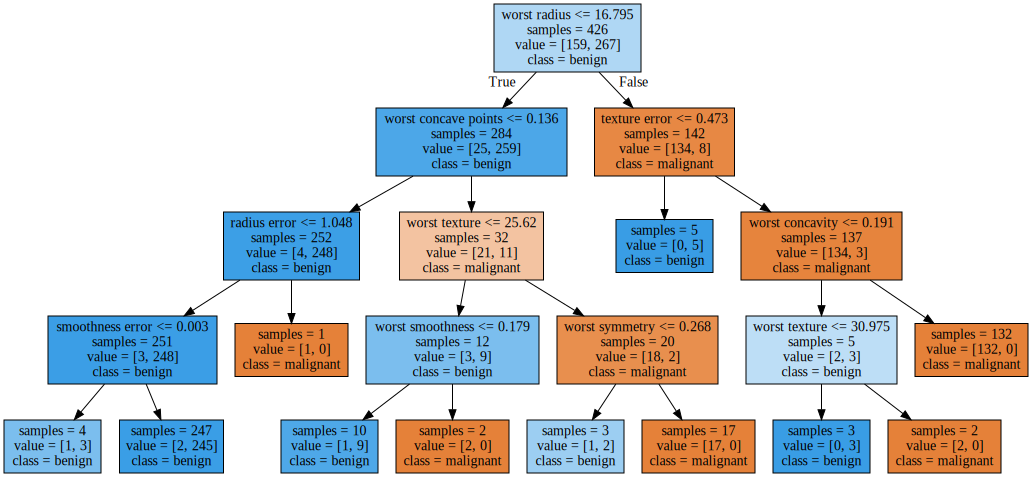

In [6]:
import graphviz
with open("tree.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

worst_radius>16.795によって作られるノードの右側では8個のbenignと134個のmalignantに分けられている。<br>
つまりそれ以降のノードはわずか8個のbenignを分けるために費やされている<br>

決定木全体を見渡すのは大変なので決定木の挙動を表す特性値を見てみる。<br>
最もよく使われるのは<b>特徴量の重要度</b>と呼ばれる。<br>
決定木が行う判断にとって、個々の特徴量がどの程度重要かを示す割合である<br>
0は全く使われていない。1は完全にターゲットを予想できる。

In [7]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


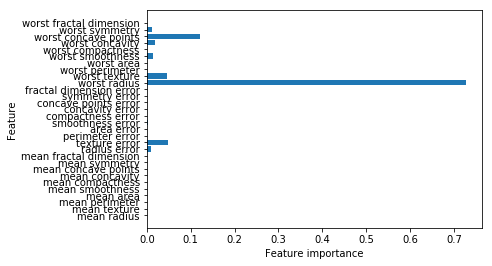

In [8]:
def plot_feature_importance_cancer(model):
    n_features=cancer.data.shape[1]
    plt.barh(range(n_features),model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features),cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importance_cancer(tree)

決定木の一番最初に用いた特徴量worst radiusが郡を抜いて重要な特徴量だとわかる。<br>
これは決定木を解析した際の最初のレベルで2つのクラスがきれいに分離できているという観察結果と一致する。<br>
しかしfeature_importance_の値が低いからといって、その特徴量の持つ情報が少ないとは限らない<br>
単にその決定木で採用されなかったというだけということもある。<br>
<b>線形モデルの係数とは異なり、特徴量の重要度は必ず正となり、特徴量がどのクラスを示しているかをエンコードしているわけではない</b><br>
worst_radiusが重要だということは教えてくれるがこの値が大きいとかならずクラス分類できるというわけではない<br>
次の例で特徴量とクラスの関係はそれほど単純ではないことがわかる
 

Feature importances: [0. 1.]


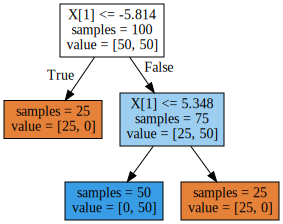

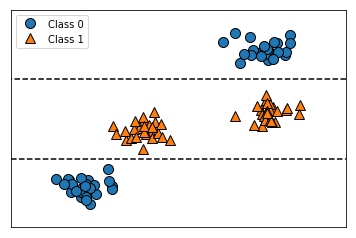

In [9]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

2つの特徴量を持つ2つのクラスからならデータセットを示している<br>
ここではすべての特徴量としてX[1]を使用しているがX[0]は使用されていない<br>
X[1]の値が多きいとクラス0になり、小さいと1になるようなことは言えない<br>

# 回帰決定木

ここはでは決定木によるクラス分類にのみ言及してきたが回帰決定木のときも同様のことが言える<br>
しかし回帰決定木で注意すべき点がある。<b>外挿ができない</b>（つまり訓練データのレンジ外については予測ができない）ということ<br>
計算機のメモリ価格を履歴データセットを使って見てみる

Text(0,0.5,'Price in $/Mbyte')

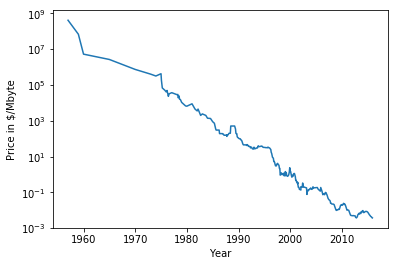

In [11]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH,"ram_price.csv"))
plt.semilogy(ram_prices.date,ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

上記データを線形回帰モデルと決定木モデルにより予測してみる。<br>
縦軸が対数スケールになっていることに注意<br>

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date<2000]
data_test = ram_prices[ram_prices.date>=2000]
X_train = data_train.date[:,np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train,y_train)
linear_reg = LinearRegression().fit(X_train,y_train)

X_all = ram_prices.date[:,np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

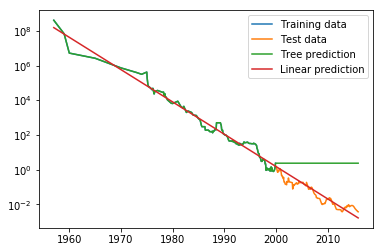

In [19]:
plt.semilogy(data_train.date,data_train.price,label="Training data")

plt.semilogy(data_test.date,data_test.price,label="Test data")
plt.semilogy(ram_prices.date,price_tree,label="Tree prediction")
plt.semilogy(ram_prices.date,price_lr,label="Linear prediction")
plt.legend()

線形モデルはデータをいい感じで直線で近似できている<br>
一方決定木は訓練データに完全に適合している。複雑さを制約していないためデータセットに過剰適合している。<br>
さらにモデルがデータを持っていない領域になると決定木は知っている最後の点を返してくるだけとなる<br>
<b>つまり決定木は訓練データにない領域に対しては「新しい」答えを生成することができない</b>

# 長所、短所、パラメタのまとめ

長所<br>
1. 結果のモデルが容易に可視化可能
1. データのスケールに対して完全に不変であること。個々の特徴量は独立に処理されデータの分割はスケールに依存しないので正規化や標準化が不要<br>

短所<br>
1. 事前刈りを行っても過剰適合しやすく汎化性能が低い傾向にある
1. 外挿できない<br>

事前枝刈りパラメタ
1. max_depth
1. max_leaf_nodes
1. min_samples_leaf<br>

決定木は単独で使うことがほとんどなく、次以降に紹介するアンサンブル法が使用される

# 決定木のアンサンブル法

アンサンブル法とは複数の機械学習モデルを組み合わせることでより精度の高いモデルを構築する手法<br>

## ランダムフォレスト

決定木最大の問題点は訓練データに対して過剰適合してしまうことにある。ランダムフォレストはそれに対応する<br>
個々の決定木は比較的うまくいっているが一部のデータに対して過剰適合してしまっているという考えに基づいている<br>
それぞれ異なる形で過剰適合してしまっている決定木に平均を取ることで過剰適合の度合いを減らす<br>
個々の決定木が異なっているため、決定木の構築段階で乱数を導入する。これには２つ方法があり<br>
決定木を作るためのデータポイントを選択する方法、分岐テストに用いる特徴を選択する方法の2つがある<br><br>

ランダムフォレストモデル構築には決定木の数を決める必要がある<br>
<b>RandomForestRegressor,RandomForestClassifierのn_estimatorsパラメータ</b><br>
決定木を作る際はブートストラップサンプリングを行う。これはn_sample個のデータポイントからランダムにn_sample個のデータポイントを選ぶ<br>
例えば[a,b,c,d]からブートストラップサンプリングをすると[b,d,d,c]や[d,a,d,a]が選ばれる<br><br>

次にそれらのデータセットを用いて決定木を作る。<br>
個々のノードの特徴量のサブセットをランダムに選び、その中から最適なテストを選ぶ。<br>
特徴量サブセットの大きさはmax_featuresで制御可能<br>
max_featuresをn_featuresに設定するとそれぞれの分岐でデータセット中のすべての特徴量を見ることになる。<br>
そのためmax_featuresを大きくするとどの決定木も似たような形になる。max_featuresを小さくするとその分、決定木が深くつくらないとデータに適合できない<br>
ランダムフォレストを用いて予測を行う際は、まずすべての決定木に対して予測を行う。回帰の場合には、これらの結果の平均値を最終的な予測として用いる<br>
クラス分類の場合にはソフト投票戦略が用いられる。それぞれの決定木が「ソフト」な予想を行う、個々の出力ラベルに対して確率を出力し、すべての決定木による確率予測を平均し、最も確率が高いラベルが予測値となる。<br>

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=100,noise=0.25,random_state=3)
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

forest = RandomForestClassifier(n_estimators=5,random_state=2,n_jobs=6)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=6,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

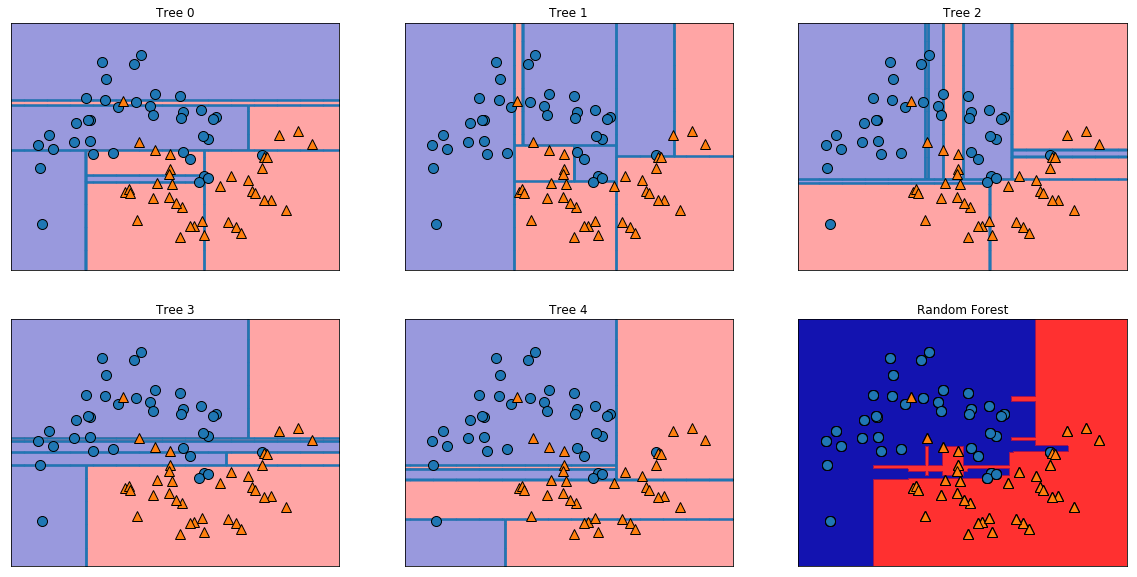

In [32]:
fig ,axes = plt.subplots(2,3,figsize=(20,10))

for i,(ax,tree) in enumerate(zip(axes.ravel(),forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train,y_train,tree,ax=ax)
    mglearn.plots.plot_2d_separator(forest,X_train,fill=True,ax=axes[-1,-1],alpha=.4)
    axes[-1,-1].set_title("Random Forest")
    mglearn.discrete_scatter(X_train[:,0],X_train[:,-1],y_train)

5つの決定木が学習した境界は明らかに相互に異なっている。それぞれの決定木は一部の点について分類に失敗している。<br>
ブートストラップサンプリングの結果、ここに表示されている訓練セットのデータポイントの一部がそれぞれの決定木が学習した際の訓練セットに含まれていなかったからである<br>
ランダムフォレストについては個々のどの決定木よりも過剰適合が少なく直感に近い決定境界を描いている。<br>
5つしか決定木を使用していないが、決定木を増やすと境界がよりなめらかになる。<br>

In [35]:
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)
forest = RandomForestClassifier(n_estimators=100,random_state=0)
forest.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(forest.score(X_train,y_train)))
print("検証セット:{:.3f}".format(forest.score(X_test,y_test)))

訓練セット:1.000
検証セット:0.972


パラメタをろくに調整してない状態でも検証セットに対して97%の精度がでている。max_featuresパラメタや個々の決定木に対して事前枝刈りを行うことでさらにチューニングすることもできる。<br>
しかし多くの場合ランダムフォレストはデフォルトのパラメタでよく機能する。<br>
決定木と同様に、ランダムフォレストでも特徴量の重要度を見ることができる。これは個々の決定木の特徴量の重要度を平均したものである。<br>

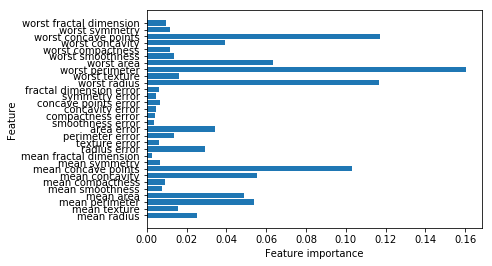

In [37]:
plot_feature_importance_cancer(forest)

ランダムフォレストでは決定木と比べて遥かに多い特徴量に対して重要度をつけている。<br>
個々の決定木よりも広い視野で特徴量の全体像を確認できるようになる。<br>

長所<br>
・決定木の利点を多く残したまま決定木の欠点の一部を補っている。<br>
・複数のCPUコアを使って簡単に並列処理ができる<br>
・特徴量の重要度の全体像が見える<br>
・非常に大きいデータセットに対しても機能する<br>
短所<br>
・決定プロセスの完結な表現がほしい場合は単独の決定木のほうが専門家以外に説明しやすい<br>
・テキストデータなどの高次元で疎なデータに対してはうまく機能しない。そういうデータは線形モデルのほうが適している<br>
・多くのメモリを消費するため訓練と予測が遅いため、実行時間やメモリが重要なアプリケーションでは線形モデルを使ったほうがよい<br>

パラメタ<br>
・n_estimator・・・決定木の数を決定する<br>
・max_feature・・・特徴量サブセットを決定する<br>
・max_depth・・・・事前枝刈りパラメータ<br>
<br>
デフォルトではクラス分類についてはmax_features=sqrt(n_features)、回帰についてはmax_features=n_featuresとなっている。<br>
max_leaf_nodeなどを追加すると性能が上がることもあり、訓練や予測に対する時間が大幅に縮まることもある

## 勾配ブースティング回帰木

複数の決定木を組み合わせてより強力なモデルを構築するもう一つのアンサンブル手法<br>
名前に回帰とついているがクラス分類、回帰にも利用できる。<br>
<b>一つ前の決定木の誤りを次の決定木が修正するようにして決定木を順番に作っていく。デフォルトでは勾配ブースティング回帰木に乱数性はない。そのかわりに強力な事前枝刈りが用いられ、深さ1～5の浅い決定木が用いられる。そのためモデルのメモリ使用量が小さく予測も早い。勾配ブースティングのポイントは浅い決定木のような簡単なモデルを多数組み合わせることにある。</b>そおれぞれの決定木は一部のデータに対して良い予測を行えないので決定木を繰り返し追加していくことで性能を向上させる。<br>
事前枝刈りとアンサンブルに用いる決定木の数を設定するパラメタに他に<b>learning_rate(学習率)</b>という重要なパラメタがある。<br>
これは個々の決定木がそれまでの決定木の過ちをどれくらい強く補正するかどうかを制御するパラメタとなる。<br>
学習率を大きくすると個々の決定木が強く補正を行うためモデルが複雑になる。n_estimatorを増やすと誤りを補正する回数も増えるため同様にモデルは複雑になる。デフォルトのlearning_rateは0.1となる<br>

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,random_state=0)

gbrt=GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(gbrt.score(X_train,y_train)))
print("検証セット:{:.3f}".format(gbrt.score(X_test,y_test)))

訓練セット:1.000
検証セット:0.958


訓練セット100%なので過剰適合していると見られる。事前枝刈りを行う。<br>

In [40]:
gbrt=GradientBoostingClassifier(random_state=0,max_depth=1)
gbrt.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(gbrt.score(X_train,y_train)))
print("検証セット:{:.3f}".format(gbrt.score(X_test,y_test)))

訓練セット:0.991
検証セット:0.972


In [41]:
gbrt=GradientBoostingClassifier(random_state=0,learning_rate=0.01)
gbrt.fit(X_train,y_train)

print("訓練セット:{:.3f}".format(gbrt.score(X_train,y_train)))
print("検証セット:{:.3f}".format(gbrt.score(X_test,y_test)))

訓練セット:0.988
検証セット:0.965


モデルの複雑さを低減するどちらの手法でも訓練セットに対する精度は下がり、検証データに対する精度は上がっている。<br>
他の決定木ベースのモデルと同様に特徴量の重要度の可視化もできる<br>

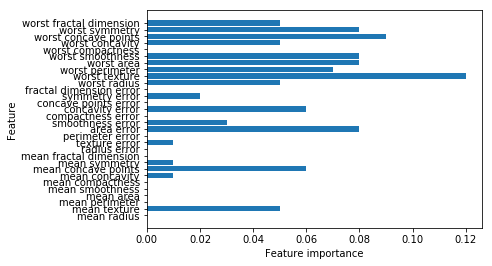

In [43]:
gbrt=GradientBoostingClassifier(random_state=0,max_depth=1)
gbrt.fit(X_train,y_train)

plot_feature_importance_cancer(gbrt)

特徴量重要度はランダムフォレストに似ているが、こちらはいくつかの特徴量重要度が完全に0となっている。<br>
勾配ブースティングとランダムフォレストは同じようなデータを得意とするので一般にはランダムフォレストを先に試したほうがよい<br>
ランダムフォレストでうまくいっても予測時間が重要な場合、機械学習モデルから最大限の性能を発揮したい場合は勾配ブースティングを試すと良い<br>

勾配ブースティングを大きい問題に適用したい場合にはxgboostパッケージとそのpythonインターフェイスを見ると良い。<br>

長所<br>
・教師あり学習の中でも協力で広く使われている。<br>
・他の決定木と同様に特徴量のスケール変換が不要<br>
短所<br>
・高次元の疎なデータに対してはうまくいかない<br>
・パラメタのチューニングに細心の注意が必要<br>
パラメタ<br>
決定木の数を指定するn_estimatorsと個々の決定木がそれまでの決定木の誤りを補正する度合いを制御するlearning_rateがある。<br>
learning_rateを小さくすると、同じ複雑さのモデルを作るにはよりたくさんの決定木が必要になるためこれらのパラメタは強く相関している。<br>
勾配ブースティングの場合はn_estimatorsを大きくすると複雑なモデルを許容することになり過学習を招く。n_estimatorsを時間とメモリ量で決めておいて、learning_rateに対して探索を行う方法がよく用いられる。<br>